## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '60m'

perc_inc = 0.008 # 0.8 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'VTI' # VTI or Vanguard Total Stock Market ETF

perc_train = 1 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = '2y' # time span of data e.g. 1y or 10y, 2y for 60m, 10y for 1d
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-06-18 08:00:00-04:00,144.150000,144.150000,143.000000,144.150000,144.150000,0
2018-06-18 09:30:00-04:00,143.281998,143.569901,143.063202,143.520996,143.520996,367516
2018-06-18 10:30:00-04:00,143.509003,143.979996,143.509003,143.840103,143.840103,301945
2018-06-18 11:30:00-04:00,143.880005,143.880005,143.580002,143.580002,143.580002,132313
2018-06-18 12:30:00-04:00,143.589996,143.899994,143.589996,143.859299,143.859299,122883


### Assign Descisions for Up %+ or Not

In [5]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [6]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,decision
Datetime,,,,,,,
2020-06-15 09:30:00-04:00,150.559998,152.410004,149.850006,151.730103,151.730103,1148437,0
2020-06-15 10:30:00-04:00,151.690002,153.229996,151.380005,152.770004,152.770004,631161,0
2020-06-15 11:30:00-04:00,152.789993,153.880005,152.429993,153.750000,153.750000,557678,0
2020-06-15 12:30:00-04:00,153.699997,154.779999,153.509995,154.330002,154.330002,462396,0
2020-06-15 13:30:00-04:00,154.309998,156.160004,153.869995,155.960602,155.960602,796158,1
2020-06-15 14:30:00-04:00,156.009995,156.149994,154.935806,154.957001,154.957001,780323,0
2020-06-15 15:30:00-04:00,154.960007,155.610001,154.289993,155.610001,155.610001,459884,0
2020-06-15 16:00:00-04:00,155.620000,155.990000,155.620000,155.800000,155.800000,0,0
2020-06-15 17:00:00-04:00,155.620000,155.660000,155.620000,155.660000,155.660000,0,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [7]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [8]:
len(decisions)

5504

In [9]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [10]:
len(decisions)

5503

In [11]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(5503, 7)

In [12]:
stock_df_one_off.iloc[-1]

Open            160.119995
High            160.119995
Low             159.279999
Close           159.794998
Adj Close       159.794998
Volume       386520.000000
decision          0.000000
Name: 2020-06-16 09:30:00-04:00, dtype: float64

In [13]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,decision
Datetime,,,,,,,
2018-06-18 08:00:00-04:00,144.150000,144.150000,143.000000,144.150000,144.150000,0,0
2018-06-18 09:30:00-04:00,143.281998,143.569901,143.063202,143.520996,143.520996,367516,0
2018-06-18 10:30:00-04:00,143.509003,143.979996,143.509003,143.840103,143.840103,301945,0
2018-06-18 11:30:00-04:00,143.880005,143.880005,143.580002,143.580002,143.580002,132313,0
2018-06-18 12:30:00-04:00,143.589996,143.899994,143.589996,143.859299,143.859299,122883,0


In [14]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    5358
1     145
Name: decision, dtype: int64

### Balance the 0's and 1's

In [15]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

145

In [16]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [17]:
stock_df_bal.shape

(290, 7)

In [18]:
stock_df_bal.decision.value_counts()

1    145
0    145
Name: decision, dtype: int64

### Train Test Split

In [19]:
X = stock_df_bal.drop(columns=['decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [21]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [22]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.7916666666666667

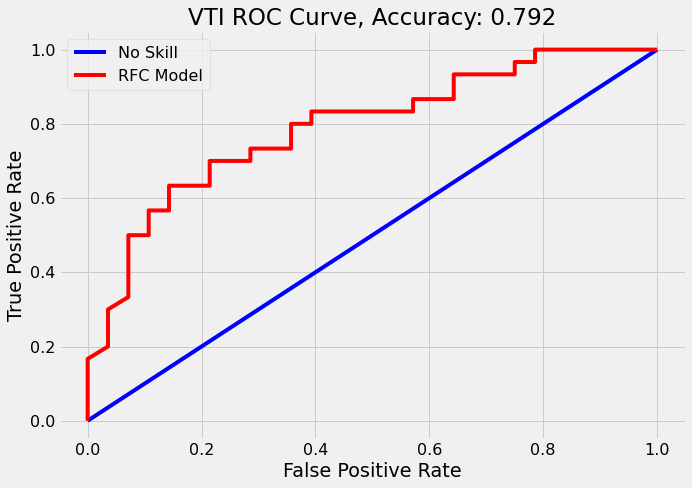

In [23]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.0s finished


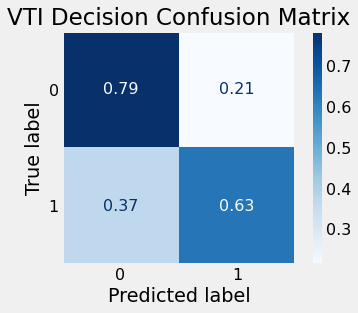

In [24]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                           , X_test
                           , y_test
                           , cmap=plt.cm.Blues
                           , normalize='true'
                     )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

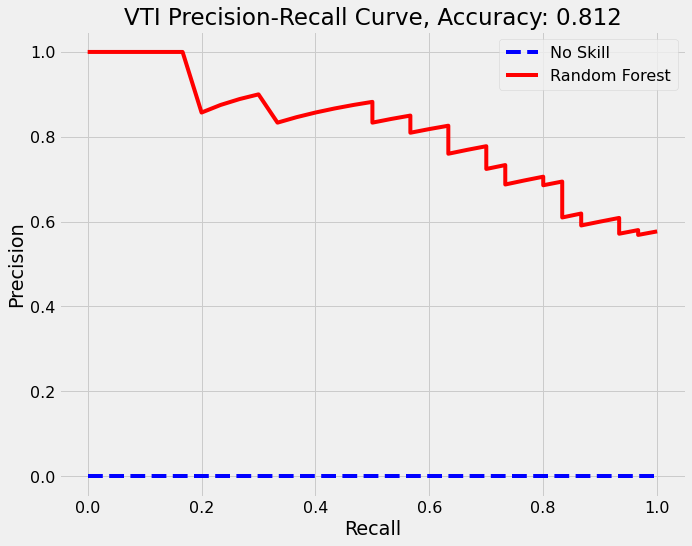

In [25]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [26]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
1,High,0.188368
2,Low,0.184207
5,Volume,0.176435
4,Adj Close,0.154683
3,Close,0.148978
0,Open,0.147329


In [27]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,decision
0,146.570000,146.570000,146.150000,146.150000,146.150000,0,0
1,145.809998,145.869995,145.610001,145.630005,145.630005,216822,0
2,147.320000,147.320000,146.310000,147.320000,147.320000,0,0
3,152.790000,152.790000,152.790000,152.790000,152.790000,0,0
4,141.130005,141.309998,140.729996,140.753098,140.753098,666922,0


### Make A Prediction

In [28]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open         159.785004
High         159.785004
Low          159.785004
Close        159.785004
Adj Close    159.785004
Volume         0.000000
Name: 2020-06-16 09:46:35-04:00, dtype: float64

In [29]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Sell or hold VTI on the 60m interval.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.0s finished
